/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


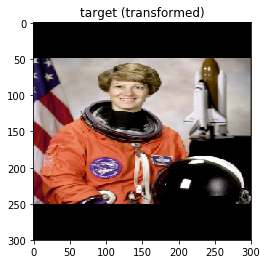

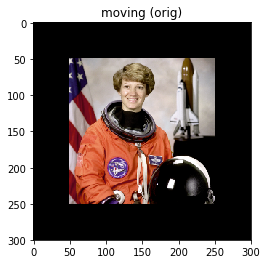

In [55]:
import copy
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
from scipy import interpolate
import skimage.data
import skimage.filters
import skimage.transform

# TODO: figure out a better way of doing this
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
# import register
import utils

im = skimage.data.astronaut()
im = np.uint8(255 * skimage.transform.resize(im, (200, 200)))

PADDED_IM_SIZE = (300, 300) 

# try warping 

true_scale = (1.5, 1)
true_rotation = 0
true_shear = 0
# true_translation = (20, -20)
true_translation = (0, 0)


aff_tfm = skimage.transform.AffineTransform(
    scale=true_scale,
    rotation=true_rotation,
    shear=true_shear,
    translation=true_translation)

im_fixed = utils.apply_matrix_tform(
    utils.resize_image(im, PADDED_IM_SIZE), aff_tfm)
im_moving = utils.resize_image(im, PADDED_IM_SIZE)

plt.figure(1)
plt.title('target (transformed)')
plt.imshow(im_fixed)
plt.figure(2)
plt.title('moving (orig)')
plt.imshow(im_moving)
plt.show()

In [91]:
"""
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html#scipy.interpolate.interp2d
"""

SAMP_SPACE = 4
xx, yy = np.meshgrid(np.arange(0, im.shape[0] / SAMP_SPACE),
                     np.arange(0, im.shape[1] / SAMP_SPACE))

im_sampled = im[::SAMP_SPACE, ::SAMP_SPACE]

xin, yin = xx.flatten(), yy.flatten()

# double checking flattening/reshaping
xx_in_out = np.reshape(xin, xx.shape)
yy_in_out = np.reshape(yin, xx.shape)

assert np.allclose(xx, xx_in_out)
assert np.allclose(yy, yy_in_out)

# list coordinates in input image
xy_in = np.array([xin, yin, np.ones(len(xin))])
shift = np.array([xx.shape[0], xx.shape[1], 0]).T / 2
shift = np.reshape(shift, (len(shift), 1))
xy_in = xy_in - shift

# apply transform
tform = aff_tfm.params
# tform = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
xy_out = np.dot(tform, xy_in).T
xy_out = xy_out + shift.T

# now transform image
xx_out, yy_out = (np.reshape(xy_out[:, 0], xx.shape),
                  np.reshape(xy_out[:, 1], xx.shape))

# now make a array for interpolation
f = interpolate.interp2d(
    xx_out, yy_out, im_sampled[:, :, 0], kind='linear')


im_new = f(xx.flatten(), yy.flatten())


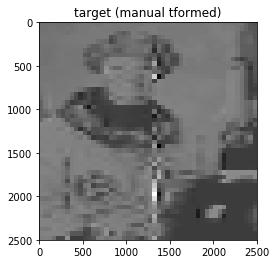

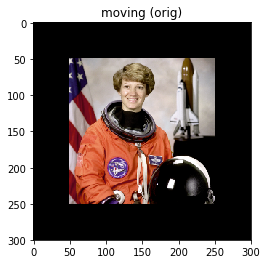

In [92]:
plt.figure(1)
plt.title('target (manual tformed)')
plt.imshow(im_new, cmap='gray')
plt.figure(2)
plt.title('moving (orig)')
plt.imshow(im_moving)
plt.show()

In [85]:
# xx
# xy_in = xy_in - np.array(xx.shape[:2] / 2)


array([25., 25.,  0.])